<a href="https://colab.research.google.com/github/khixson1/Neural_Network_Kaggle_Competition_Exercise/blob/main/Neural_Network_Kaggle_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Network Kaggle Competition Exercise

Kim Hixson

# Ventilator Pressure Prediction
https://www.kaggle.com/competitions/ventilator-pressure-prediction/data

The ventilator data used in this competition was produced using a modified open-source ventilator connected to an artificial bellows test lung via a respiratory circuit. The diagram below illustrates the setup, with the two control inputs highlighted in green and the state variable (airway pressure) to predict in blue. The first control input is a continuous variable from 0 to 100 representing the percentage the inspiratory solenoid valve is open to let air into the lung (i.e., 0 is completely closed and no air is let in and 100 is completely open). The second control input is a binary variable representing whether the exploratory valve is open (1) or closed (0) to let air out.

In this competition, participants are given numerous time series of breaths and will learn to predict the airway pressure in the respiratory circuit during the breath, given the time series of control inputs.

In [1]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import TensorFlow libraries
%%capture
!pip install tensorflow

In [3]:
# Imports
# Standard imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Standard Scaler and train test split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix


# Neural Network imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

#for viewing pipeline
from sklearn import set_config
set_config(display='diagram')

In [4]:
# Upload data and view info

train_link = 'train.csv'
test_link = 'test.csv'

train = pd.read_csv(train_link)
test = pd.read_csv(test_link)

In [5]:
# Viewing the test.csv file
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


None

In [6]:
# Training dataset view

display(train.info())
display(train.describe())
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154794 entries, 0 to 3154793
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 192.6 MB


None

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,3.154794e+06,3.154794e+06,3.154794e+06,3.154794e+06,3.154794e+06,3.154794e+06,3.154794e+06,3.154794e+06
mean,1.577398e+06,3.278188e+04,2.697980e+01,2.596344e+01,1.307298e+00,7.362535e+00,6.204814e-01,1.124534e+01
std,9.107107e+05,1.896028e+04,1.959809e+01,1.711709e+01,7.660201e-01,1.350256e+01,4.852673e-01,8.133315e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,7.886992e+05,1.637600e+04,5.000000e+00,1.000000e+01,6.429229e-01,4.112147e-01,0.000000e+00,6.329607e+00
50%,1.577398e+06,3.277400e+04,2.000000e+01,2.000000e+01,1.308179e+00,4.392129e+00,1.000000e+00,7.032628e+00
75%,2.366096e+06,4.924900e+04,5.000000e+01,5.000000e+01,1.965553e+00,4.984195e+00,1.000000e+00,1.378163e+01
max,3.154794e+06,6.562400e+04,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
# Check for missing data
train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [8]:
# Check for duplicates
train.duplicated().sum()

0

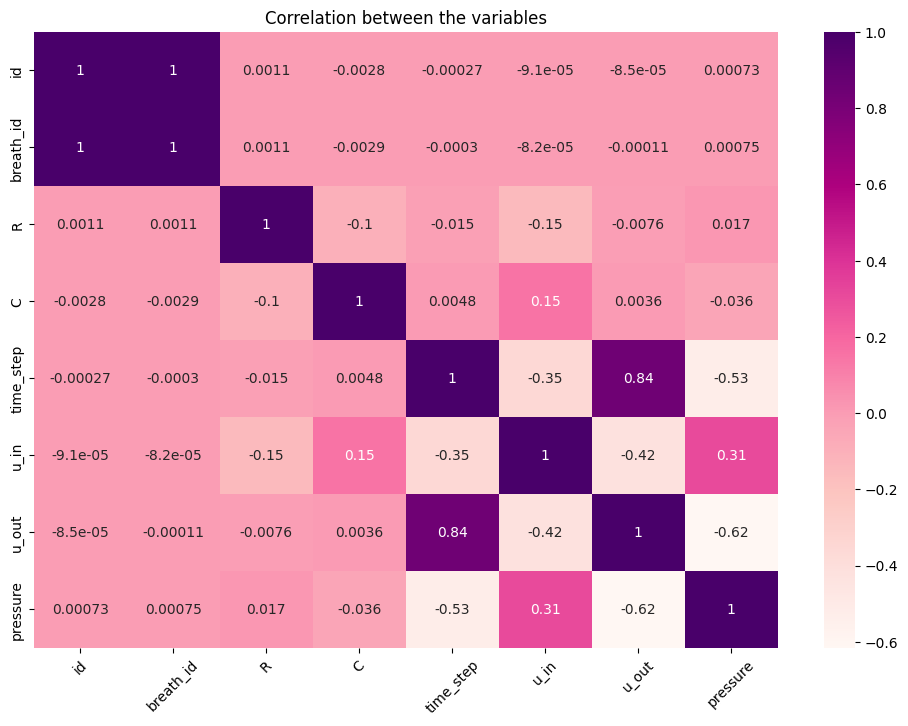

In [9]:
#correlation matrix and the heatmap;
plt.subplots(figsize=(12,8));
corr=train.corr();
sns.heatmap(corr,annot=True,cmap='RdPu');
plt.title('Correlation between the variables');
plt.xticks(rotation=45);

# Create Neural Network Model

In [10]:
X = train.drop(columns=['id', 'breath_id', 'pressure'])
y = train['pressure']

In [11]:
# Model Validation (Train Test Split on Train.csv data)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
# Scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Step 1: Define our network structure
# Save the number of features we have as our input shape
input_shape = X_train.shape[1]
input_shape

5

In [14]:
# Sequential model
model = Sequential()

In [15]:
# First hidden layer
model.add(Dense(5, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
model.add(Dropout(.2)) # Add dropout regularization

# Second hidden layer
model.add(Dense(3, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
model.add(Dropout(.2)) # Add dropout regularization

# Output layer
model.add(Dense(1, activation = 'linear'))

# Compile Model
model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae'])

# Apply Early Stopping
early_stopping = EarlyStopping(patience = 3)

In [ ]:
# Fit the model

history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs=10,
                    callbacks = [early_stopping])

Epoch 1/10
73941/73941 [==============================] - 223s 3ms/step - loss: 44.5446 - mae: 4.2394 - val_loss: 31.4911 - val_mae: 3.7136
Epoch 2/10
73941/73941 [==============================] - 219s 3ms/step - loss: 40.8220 - mae: 4.0912 - val_loss: 32.4075 - val_mae: 3.7308
Epoch 3/10
73941/73941 [==============================] - 217s 3ms/step - loss: 40.8354 - mae: 4.0925 - val_loss: 31.4643 - val_mae: 3.7142
Epoch 4/10
73941/73941 [==============================] - 217s 3ms/step - loss: 40.8472 - mae: 4.0927 - val_loss: 32.2461 - val_mae: 3.7200
Epoch 5/10
73933/73941 [============================>.] - ETA: 0s - loss: 40.8072 - mae: 4.0918

In [ ]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [ ]:
# Visualize the loss
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Test MAE')
plt.legend();

# Make Predictions and Evaluate Model

In [ ]:
# drop id and breath_id columns to match the training data
test_df = test.drop(columns=['id', 'breath_id'])

In [ ]:
# scale the test data
test_scaled = scaler.transform(test_df)

In [ ]:
# Using the test data provided by Kaggle we will make our predictions using our neural network model
y_pred = model.predict(test_scaled)

In [ ]:
# view y_pred
y_pred[0:5]

In [ ]:
# make array into dataframe
y_pred_df = pd.DataFrame(list(y_pred))

In [ ]:
len(y_pred_df)

In [ ]:
id_col = list(range(1, 1 + len(y_pred_df)))
id_col = pd.DataFrame(id_col, columns=['id'])
id_col.head()

In [ ]:
# make y_pred into a dataframe and add 'id' column
submission = pd.concat([id_col, y_pred_df], axis=1)
submission = submission.rename(columns={'id':'id', 0:'pressure'})
submission.head()

In [ ]:
# save predictions as csv to submit to Kaggle
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Coding Dojo/DataScience_Stack3/Week_11_AdvancedML_IntroToDeepLearning/Datasets/sample_submission.csv', index=False)

# Show screenshot of Kaggle entry

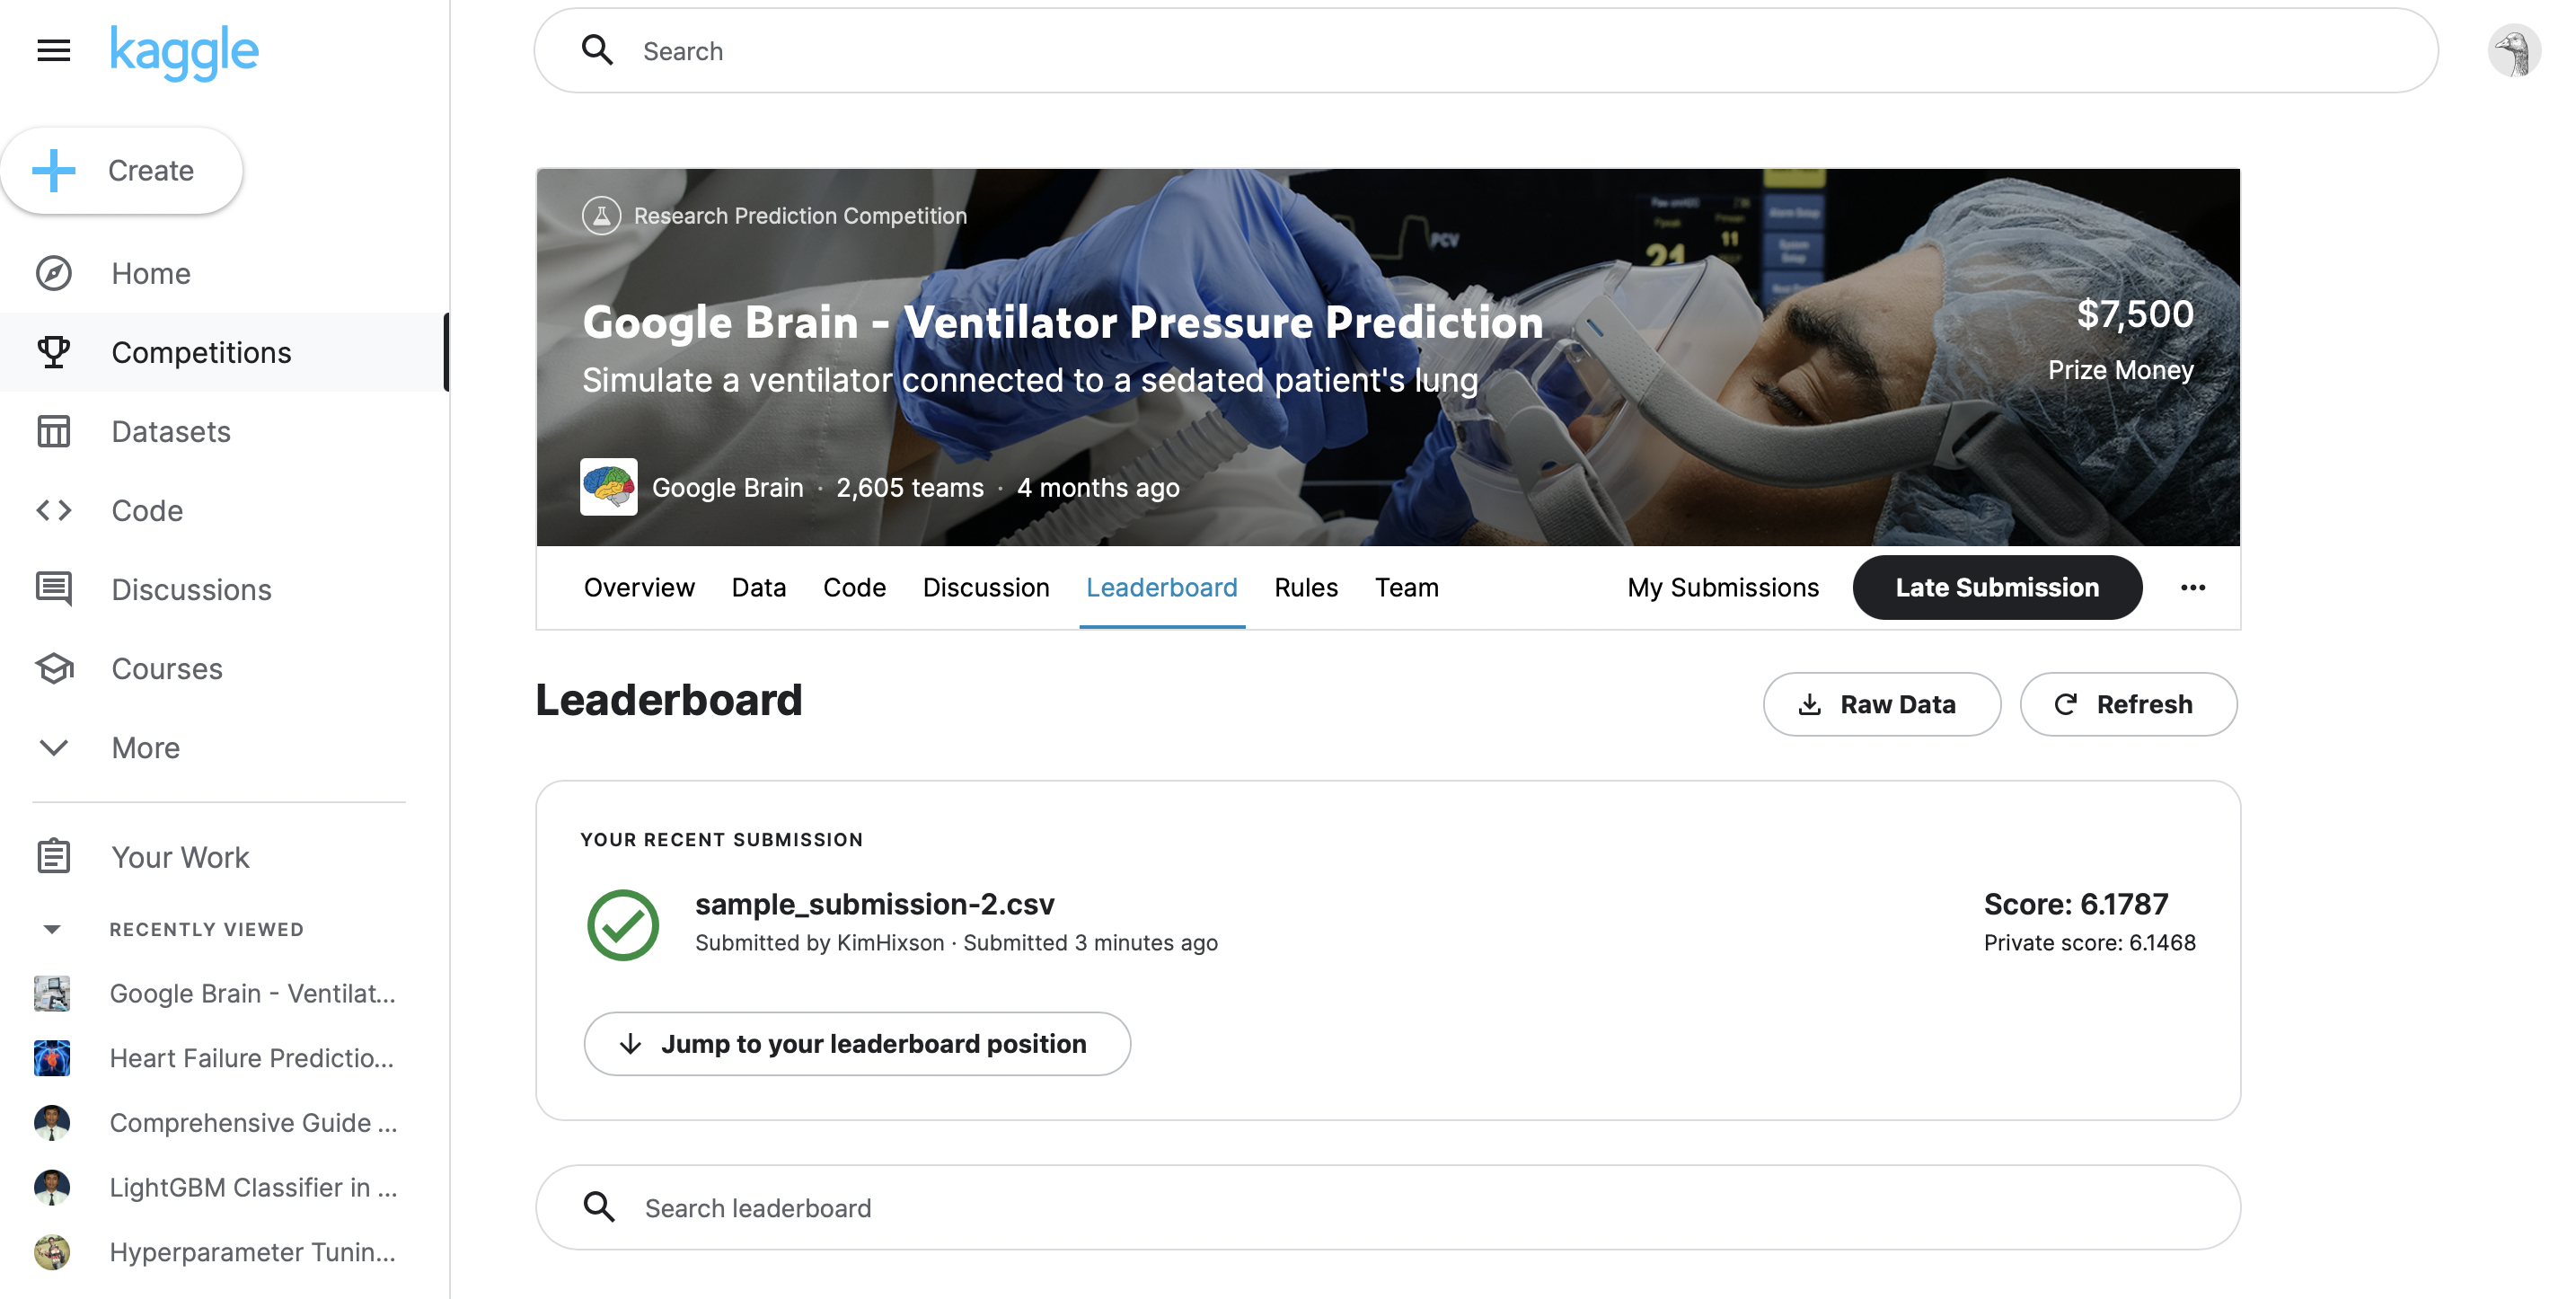

I achieved a worse score with the neural network of 6.1787. My previous score was 4.1641 with the gradient boosting model.